In [1]:
from collections import Counter
import pandas as pd
import psycopg2
import re
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
import matplotlib.ticker
import seaborn as sns
from settings import *

In [2]:
emojis_str = r"""(?:
                [:=;] # Eyes
                [oO\-]? # Nose
                [D\)\]\(\]/\\OpP] # Mouth
                )"""

regex_str = [
    emojis_str,
    r'<[^>]+>',  # HTML tags
    r'(?:@[\w_]+)',  # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)",  # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+',  # URLs
    r'(?:(?:\d+,?)+(?:\.?\d+)?)',  # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])",  # words with - and '
    r'(?:[\w_]+)',  # other words
    r'(?:\S)'  # anything else
]

In [3]:
tokens_re = re.compile(r'(' + '|'.join(regex_str) + ')', re.VERBOSE | re.IGNORECASE)
emojis_re = re.compile(r'^' + emojis_str + '$', re.VERBOSE | re.IGNORECASE)

In [4]:
punctuations = list(string.punctuation)
stopwords = stopwords.words('english') + punctuations + ['rt', 'via']

In [5]:
def get_df():
    conn = psycopg2.connect(
        database="software_jobs", user="postgres", password=POSTGRESDB_PWD,
        host='localhost')

    tweets_df = pd.read_sql_query('SELECT * FROM software_jobs', con=conn)

    return tweets_df

In [6]:
def tokenize_tweet(tweet_text):
    return tokens_re.findall(tweet_text)

In [7]:
def preprocess_tweet(tweet_text, lowercase=False):
    tokens = tokenize_tweet(tweet_text)
    tokens = [token if emojis_re.search(token) else token.lower() for token in tokens]
    tokens = [token for token in tokens if token not in stopwords]

    return tokens

In [8]:
def filter_hashtags(tweet_text):
    tokens = [token for token in preprocess_tweet(tweet_text) if token.startswith('#')]
    return tokens

In [9]:
def filter_terms(tweet_text):
    tokens = [token for token in preprocess_tweet(tweet_text) if not token.startswith(('#', '@'))]
    return tokens

In [10]:
def plot_freq_chart(df, feature, palette):
    
    fig, ax = plt.subplots(figsize=(16, 10))
    sns.set(style="whitegrid")
    sns.barplot(x=feature, y='frequency', data=df, ax=ax, palette=palette)
    plt.title(f'Top 10 frequent {feature}', size=18)
    plt.xlabel(f'{feature}', size=18)
    plt.ylabel(f'{feature} count', size=18)
    plt.xticks(rotation='vertical', size=14)
    plt.yticks(size=14)
    formatter = matplotlib.ticker.StrMethodFormatter("{x:.0f}")
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.show()
    # plt.savefig(f"freq_{feature}.png")

In [11]:
def get_freq_words():
    tweets_df = get_df()
    tweets_df["tweet_text"] = tweets_df["tweet_text"].apply(preprocess_tweet)
    freq_words = tweets_df["tweet_text"].tolist()
    freq_words_l = [word for sublist in freq_words for word in sublist]
    word_count = Counter(freq_words_l).most_common(10)
    freq_words_df = pd.DataFrame(word_count, columns=['words', 'frequency'])
    plot_freq_chart(freq_words_df, 'words', 'winter')

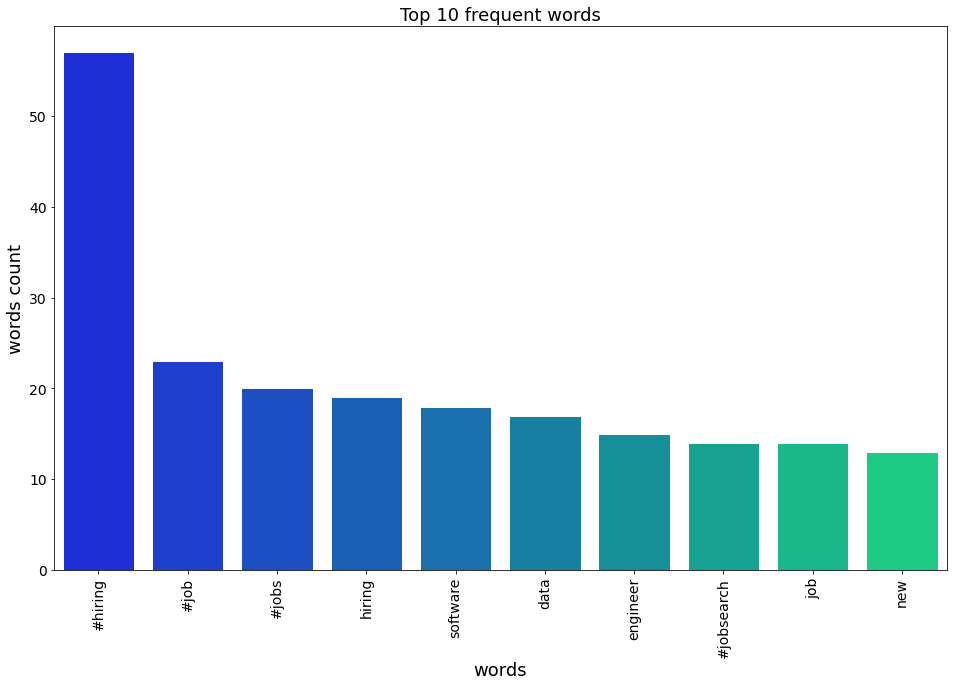

In [12]:
get_freq_words()

In [13]:
def get_freq_hashtags():
    tweets_df = get_df()
    tweets_df["tweet_text"] = tweets_df["tweet_text"].apply(filter_hashtags)
    hashtags = tweets_df["tweet_text"].tolist()
    hashtags_l = [word for sublist in hashtags for word in sublist]
    hashtags_count = Counter(hashtags_l).most_common(10)
    freq_hashtags_df = pd.DataFrame(hashtags_count, columns=['hashtags', 'frequency'])
    plot_freq_chart(freq_hashtags_df, 'hashtags', 'tab20')

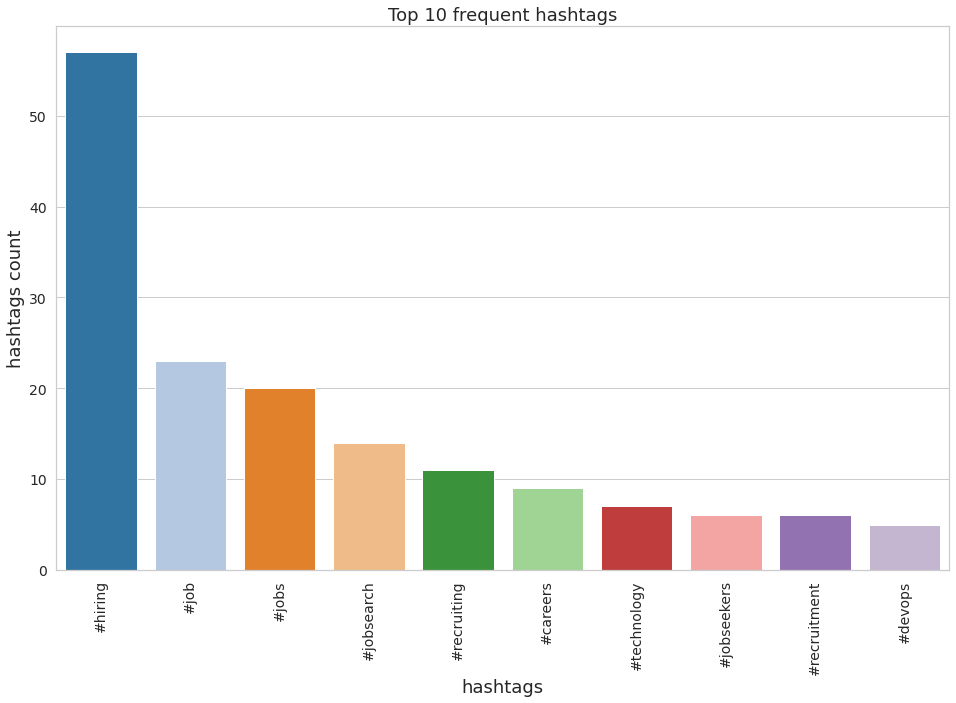

In [14]:
get_freq_hashtags()

In [15]:
def get_freq_terms():
    tweets_df = get_df()
    tweets_df["tweet_text"] = tweets_df["tweet_text"].apply(filter_terms)
    filtered_terms = tweets_df["tweet_text"].tolist()
    filtered_terms_l = [term for sublist in filtered_terms for term in sublist]
    terms_count = Counter(filtered_terms_l).most_common(10)

    terms_freq = pd.DataFrame(terms_count, columns=['terms', 'frequency'])
    print("===========frequent terms - no hashtags/mentions===========")
    plot_freq_chart(terms_freq, 'terms', 'ocean')

===========frequent terms - no hashtags/mentions===========


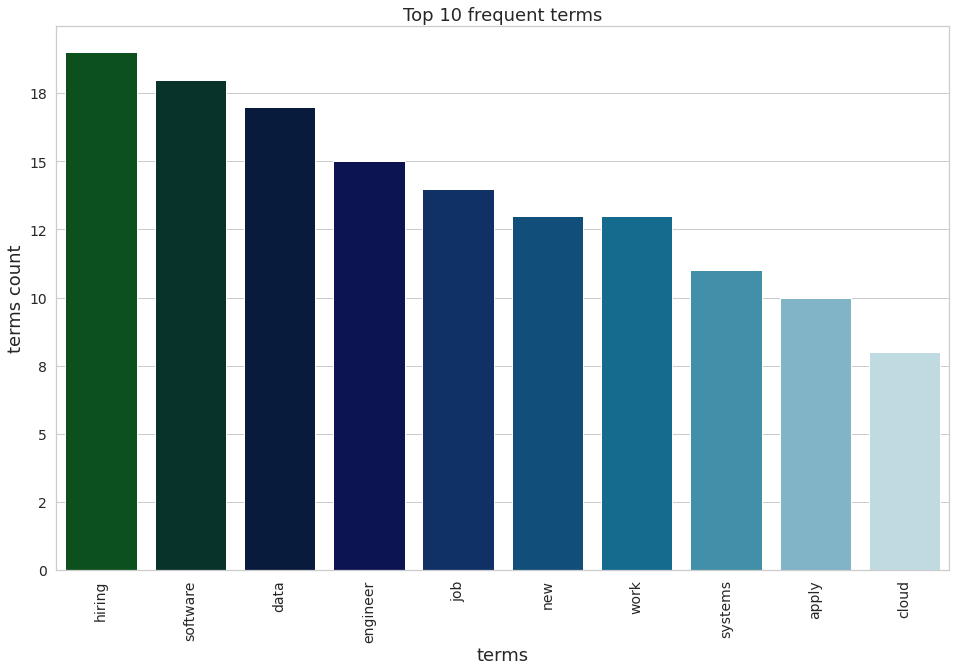

In [16]:
get_freq_terms()